Charged particle above fixed oppositely charged ring.

If the particle is placed, on axis, a distance z above the centre of the ring and released, the force on the particle can be found by integrating around the ring. In the case that z << r, the radius of the ring, then the force is approximately proportional the displacement. Hence SHM will occur. Otherwise the motion produced is non-trivial, especially if the particle is placed off-axis.

Using the above, it can be noted that for 2 fixed particles the linear restoring force occurs at all angles normal to the line connecting them. A charged particle in this plane, close to the midpoint, will then be capable of circular motion about the midpoint. However as the distance to the midpoint increases, z is not longer << r and the force no longer proportional to z, this will mean that the orbits will no longer close.

Importing numpy along with matplotlib.pyplot and various tools from the matplotlib library. The "TKAgg" backend is used along with the %matplotlib notebook in order to allow interactive plots within the notebook

In [8]:
import numpy as np
import matplotlib
matplotlib.use('tkagg')
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from matplotlib.widgets import Slider, Button, RadioButtons
from mpl_toolkits.mplot3d.axes3d import Axes3D

%matplotlib notebook

Functions which define the RK4 routine and the acceleration caused by the charged ring (which is modelled as point particle sections as a approximation to the integration required). Also a function to calculate the SHM frequency found if the displacement of the particle is assumed to be much less than the radius of the ring.

In [9]:
def rk4(R,V,a,h,ring_r,ring_steps,q):
	# Function to time step using the Runge-Kutta 4th order algorithm
	# V - velocity vector of the particle(s)
	# R - position vector of the particle(s)
	# a - function which outputs the acceleration of the particle
	# h - time step size
	# ring_r,ring_steps,q - parameters used in the a() function

	# First
	r_1 = R
	v_1 = V
	a_1 = a(r_1,ring_r,ring_steps,q)

	# Second
	r_2 = r_1 + 0.5*v_1*h
	v_2 = v_1 + 0.5*a_1*h
	a_2 = a(r_2,ring_r,ring_steps,q)

	# Third
	r_3 = r_1 + 0.5*v_2*h
	v_3 = v_1 + 0.5*a_2*h
	a_3 = a(r_3,ring_r,ring_steps,q)

	# Fourth
	r_4 = r_1 + v_3*h
	v_4 = v_1 + a_3*h
	a_4 = a(r_4,ring_r,ring_steps,q)

	# Final position and velocity
	r_f = R + (h/6.0)*(v_1+2*v_2+2*v_3+v_4)
	v_f = V + (h/6.0)*(a_1+2*a_2+2*a_3+a_4)

	return r_f,v_f

def a(R,ring_r,ring_steps,q):
	# Function to calculate the acceleration of the particle(s) at position R
	# R - position vector of the the particle(s)
	# ring_r -  radius of the charged ring
	# q - ratio of the charge on the particle to that on the ring
	# ring_steps - Number of sections of ring considered	

	# Charge density of the ring
	rho = q/(2*np.pi*ring_r)

	# Azimuthal angle steps
	phi_h = 2*np.pi/float(ring_steps)
	
	total_acc = np.array((0.0,0.0,0.0))
	for i in range(ring_steps):
		# Azimuthal angle
		phi = i*phi_h
		# Relative position vector of particle to element of ring dq
		P = R-np.array((ring_r*np.cos(phi),ring_r*np.sin(phi),0))
	
		# Magnitude of the relative position vector
		P_mag = np.linalg.norm(P)

		acc = -ring_r*phi_h*rho*P/(4*np.pi*P_mag**3)

		total_acc = total_acc + acc

	return total_acc

def shm_freq(ring_r,q):
	return (q/(4*np.pi*ring_r**3))**0.5

Animation object, contains the necessary methods to create an interactive animation of the motion of the charged particle near the ring. Sliders are introduced to modify parameters and a run button which will restart the animation for these new parameters. The RK4 routine is run before producing the plotting to allow for a smooth animation. Also contains if statements for when the number of ring elements is set to 2 for the later investigation

In [10]:
class Animation(object):

	def __init__(self,q,ring_r,ring_steps,h,N,N_output):
		# Initialising values from the presets given at the end of this file
		self.q = q
		self.ring_r = ring_r
		self.ring_steps = ring_steps
		self.h = h
		self.N = N
		self.N_output = N_output
		
		# Initialises the tracer to be off
		self.trace = False

	def create_plot(self,R_i,V_i):
		# Records the initial position and velocity
		self.R_i = R_i
		self.V_i = V_i

		# Creates a figure which is twice as wide as it is tall
		self.fig = plt.figure(figsize = plt.figaspect((0.5)))

		# First subplot - 3D plot which tracks the particle motion
		self.ax1 = self.fig.add_subplot(1,2,1, projection='3d')
		# Setting the x and y axis limits
		self.ax1.set_xlim3d([-self.ring_r,self.ring_r])
		self.ax1.set_ylim3d([-self.ring_r,self.ring_r])
		# For the 2 fixed particles case, zoom in on the y axis		
		if self.ring_steps == 2:
			self.ax1.set_ylim3d([-1.5*self.R_i[2],1.5*self.R_i[2]])
		self.ax1.set_zlim3d([-1.5*self.R_i[2],1.5*self.R_i[2]])
		# Draw the ring on this subplot
		self.draw_ring()

		# Second subplot - 2D plot showing the displacements as a function of time
		self.ax2 = self.fig.add_subplot(1,2,2)
		# Time is in arb. units so remove to accomodate slider
		self.ax2.get_xaxis().set_ticks([])
		z_max = self.R_i[2]
		self.ax2.set_xlim([0.0,self.h*self.N])
		if self.ring_steps == 2:
			# For 2 fixed particle case, orbit is not confined to within the initial particle height
			self.ax2.set_ylim([-2.0*z_max,2.0*z_max])
		else:
			self.ax2.set_ylim([-z_max,z_max])

		# Create lines to be later referenced for the particle and the tracer
		self.particle = self.ax1.plot([self.R_i[0]],[self.R_i[1]],[self.R_i[2]],'ro')[0]
		self.tracer = self.ax1.plot([self.R_i[0]],[self.R_i[1]],[self.R_i[2]],'r-.')[0]

		# Create lines to be later referenced for the 2 lines on the 2D plot
		self.z1_plot = self.ax2.plot([0.0],[z_max],'b-')[0]
		self.z2_plot = self.ax2.plot([0.0],[z_max],'r-')[0]

	def draw_ring(self):
		# Draws equally spaced in angle sections of the ring
		for i in range(self.ring_steps):
			phi_h = 2*np.pi/float(self.ring_steps)
			x = self.ring_r*np.cos(i*phi_h)
			y = self.ring_r*np.sin(i*phi_h)
			self.ax1.plot([x],[y],[0.0],'bo')

	def create_sliders(self):
		# Positioning of sliders
		axp_s = 0.02
		# Slider index
		si = 0
		# Slider width
		sw = 0.02
		
		# Starting height of particle slider
		# Positioning of slider/button
		self.ax_h = plt.axes([0.15,axp_s+si*(0.01+sw),0.65,sw])
		# Creating the slider/button object
		self.s_h = Slider(self.ax_h,'Particle Height',0.001,5.0, valinit= self.R_i[2])
		# Telling the slider/button which function to call when changed/pressed
		self.s_h.on_changed(self.update)
		si = si+1

		# Charge factor slider
		self.ax_q = plt.axes([0.15,axp_s+si*(0.01+sw),0.65,sw])
		self.s_q = Slider(self.ax_q,'Charge Factor',100.0,10000.0, valinit = self.q)
		self.s_q.on_changed(self.update)
		si = si+1

		# Run button
		self.ax_b = plt.axes([0.15,1.0 - (0.04+sw),0.3,1.75*sw])
		self.b_run = Button(self.ax_b,'Run (with new values)')
		self.b_run.on_clicked(self.mainloop)

		# Tracer button
		self.ax_t = plt.axes([0.575,1.0 - (0.04+sw),0.3,1.75*sw])
		self.rb_t = Button(self.ax_t,'Tracer On/Off')
		self.rb_t.on_clicked(self.t_onoff)

		plt.show()

	def run_anim(self,R_rec,V_rec):
		# Retrieve the data produced by the RK4 routine
		self.R = R_rec
		self.V = V_rec
		# Adjusting limits in case they have been changed by slider changes
		if self.ring_steps == 2:
			self.ax1.set_ylim3d([-1.5*self.R_i[2],1.5*self.R_i[2]])
			self.ax2.set_ylim([-2.0*self.R_i[2],2.0*self.R_i[2]])
		else:
			self.ax2.set_ylim([-self.R_i[2],self.R_i[2]])
			self.shm_f = shm_freq(self.ring_r,self.q)
		self.ax1.set_zlim3d([-1.5*self.R_i[2],1.5*self.R_i[2]])

		# Animation functions
		def nextframe(arg):
			# Update particle position
			self.particle.set_data(self.R[0:2,arg])
			self.particle.set_3d_properties(self.R[2,arg])
			
			# Update tracer (if on)
			if self.trace:
				self.tracer.set_data(self.R[0:2,:arg])
				self.tracer.set_3d_properties(self.R[2,:arg])
			else:
				self.tracer.set_data(self.R_i[0:2])
				self.tracer.set_3d_properties(self.R_i[2])

			frame_num = arg+1
			time = np.linspace(0.0,self.h*self.N_output*arg,frame_num)
			if self.ring_steps == 2:
				# Plot z and y displacements as functions of time
				self.z1_plot.set_data(time,self.R[2,:frame_num])
				self.z2_plot.set_data(time,self.R[1,:frame_num])
			else:
				# Plot z and SHM approx as functions of time
				self.z1_plot.set_data(time,self.R[2,:frame_num])
				self.z2_plot.set_data(time,self.R[2,0]*np.cos(self.shm_f*time))
		try:
			# Halt previous animation after settings change
			self.animate._stop()
		except:
			# First time around there will be no animation to terminate so catch exception
			print('No FuncAnimation to stop')
		# Create animation object which calls nextframe function in 100ms intervals
		self.animate = anim.FuncAnimation(self.fig, nextframe, self.N/self.N_output, interval = 100, blit = False)
		plt.show()

	def t_onoff(self,val):
		# On button press, change values of trace bool
		if self.trace:
			self.trace = False
		else:
			self.trace = True

	def update(self,val):
		# Slider value changes
		self.q = self.s_q.val
		self.R_i = np.array((self.R_i[0],self.R_i[1],self.s_h.val))

	def mainloop(self,event):
		print('Commencing RK4 routine...')
		
		R = np.zeros((3))
		V = np.zeros((3))
		R = self.R_i
		V = self.V_i

		if self.ring_steps == 2:
			# Give particle velocity required to perform circular orbit (if SHM approx holds)
			V[1] = self.R_i[2]*shm_freq(self.ring_r,self.q)

		# Record arrays:
		R_rec = np.zeros((3,N/N_output))
		V_rec = np.zeros((3,N/N_output))
		i_rec = 0
		for i in range(N):
			R,V = rk4(R,V,a,self.h,self.ring_r,self.ring_steps,self.q)
			# Only record every N_output result from rk4() for efficiency
			if (i%N_output) == 0:
				R_rec[:,i_rec] = R
				V_rec[:,i_rec] = V
				i_rec = i_rec + 1	

		print('RK4 time stepping has been completed')

		self.run_anim(R_rec,V_rec)

Contains the necessary initial parameters and creates an Animation object for the user to interact with. Off axis starting positions can be investigated by changing the R vector, where the components represent (x,y,z), below.

<IPython.core.display.Javascript object>


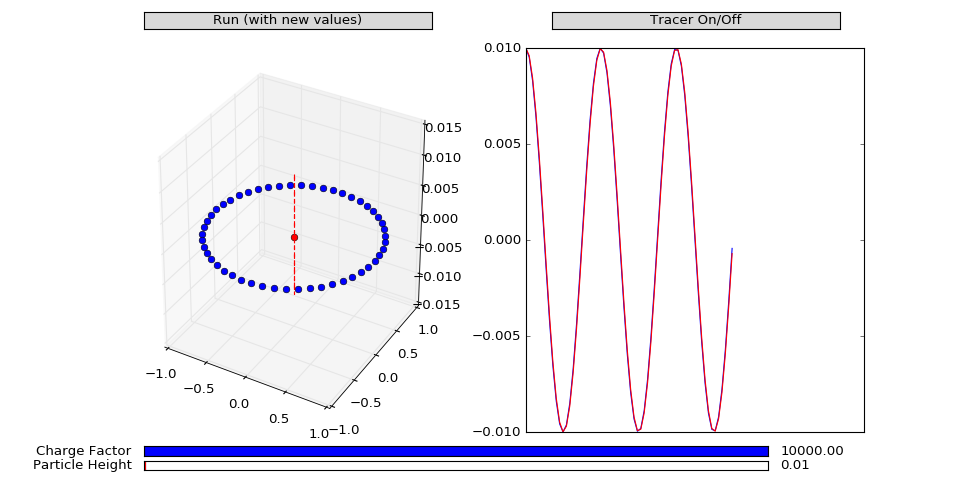

In [19]:
# initial conditions
# Particle position and velocity
R = np.array((0.0,0.0,0.01))
V = np.array((0.0,0.0,0.0))

# Ring radius
ring_r = 1.0
# Ring sections
ring_steps = 50
# Charge factor = qQ/epsilon_0
q = 10000.0

# Time step
h = 10.0**-3
N = 1000

# Animation frame change
N_output = 10

Anim = Animation(q,ring_r,ring_steps,h,N,N_output)
Anim.create_plot(R,V)
Anim.create_sliders()

The left hand graph shows the position of the particle in red and the ring in blue. The right hand graph shows the z value of the particle as a function of time (blue for actual position and red shows SHM approximation). The two sliders control the charge factor (q Q / epsilon_0) and the height from which the particle is dropped.

Note the left hand graph can be dragged to reposition the view point.

For small particle heights the SHM approximation is very good but as the dropping height becomes comparable to the the size of the ring then it breaks down.

Some interesting/fun simulations to try:

    Initial position R = (0.01,0.01,0.5)
    
    Initial velocity - at rest
    
    Charge factor 10,000
    
    Ring sections 50 and ring radius 1
    
-> This produces some nice looping motion about the ring.

Now looking at the orbit of the charged particle about 2 fixed charges, at close distances there should be a linear restoring force so closed orbits must be possible. However at larger distances this should no longer hold and anharmonic behaviour will occur.

<IPython.core.display.Javascript object>


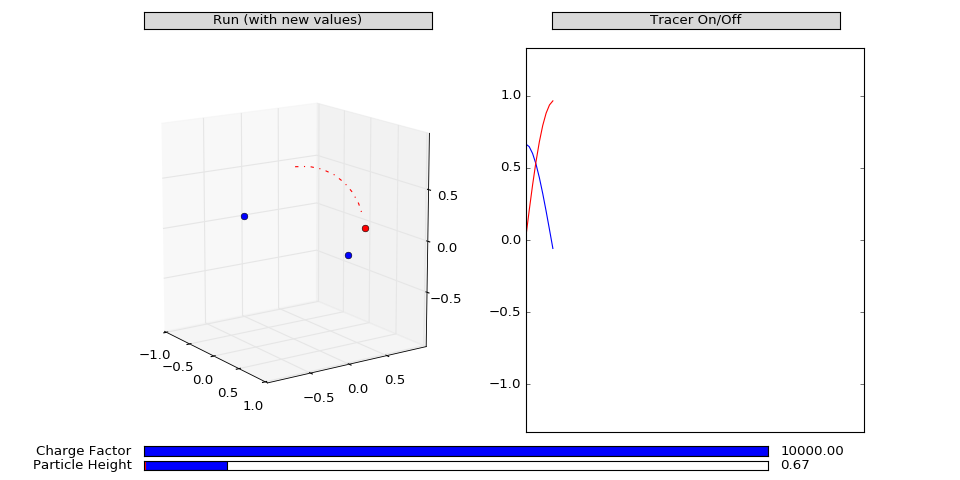

In [18]:
Anim.R_i = np.array((0.0,0.0,0.01))
Anim.ring_steps = 2
Anim.create_plot(R,V)
Anim.create_sliders()

Now for the right hand graph, blue still represents the z displacement of the particle but red now represents the y displacement. At small particle heights you should see two sinusoids, pi/4 out of phase, as expected for circular motion.

However at larger distances (e.g. try a "particle height" of ~ 0.65) this behaviour is lost and the orbit is no longer closed c.f. Bertrand's theorem. Turn on the tracer to see the precession of the semi-major axis in the left hand plot.